In [1]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim, no_grad

from sklearn import datasets
from time import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter

torch.set_default_tensor_type(torch.DoubleTensor) 

# Utilitaries

In this section, we define useful fonctions for the TP. No need to change anything here.

### Dataset

Here we load the convenient dataset (MNIST) and make it useable (by rescaling each pixel between 0 and 1 for example)

In [3]:
# We specify the location of the data to load and the transformation to apply to the data
_root = "./data"
_trans = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.0,), (1.0,)),
    ]
)
# Load the data! We use MNIST
train_dataset = dset.MNIST(root=_root, train=True, transform=_trans, download=True)
test_and_val_dataset = dset.MNIST(root=_root, train=False, transform=_trans, download=True)

# Now we separate the "test and val" dataset between validation and test datasets
val_dataset = list()
test_dataset = list()
validation_size = 1000
for i, x in enumerate(test_and_val_dataset):
    if i < validation_size:
        val_dataset.append(x)
    else:
        test_dataset.append(x)

In [4]:
# Create the loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=True, batch_size=1)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1000, shuffle=True)

### Model

In [5]:
# We define a MNIST LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x = x.view(-1, 1, 28 * 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### Training

In [6]:
def compute_accuracy(model, loader):
    correct = 0
    model.eval()
    with no_grad():
        for data, target in loader:
            data = data.double()
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(loader.dataset)
    return acc

In [13]:
def go_training(x,y, model, optimizer, loss_func, adv, eps):
    x = x.double()
    optimizer.zero_grad()
    if not adv:
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        loss.backward()
        optimizer.step()
    elif adv:
        x_adv = fgsm_attack(model, x, y, epsilon=eps)
        y_pred_adv = model(x_adv)
        loss = loss_func(y_pred_adv, y)
        loss.backward()
        optimizer.step()

In [9]:
def train_network(model, train_loader, val_loader, loss_func, epochs, adv=False, eps=0.15):
    lr = 0.001
    patience = 20
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=patience, verbose=True, factor=0.5)
    
    loss_history = []
    t = time()
    for epoch in range(epochs):
        print(f"Starting epoch {epoch} ({time()-t} secs) and lr = {[param['lr'] for param in optimizer.param_groups]}")
        t = time()
        
        for x, y in train_loader:
            go_training(x,y, model, optimizer, loss_func, adv, eps)
        
        for x_val, y_val in val_loader:
            x_val = x_val.double()
            y_val_pred = model(x_val)
            val_loss = loss_func(y_val_pred, y_val)
            print(f"Validation loss = {np.around(val_loss.item(), decimals=4)}")
            loss_history.append(val_loss.item())
        scheduler.step(val_loss)
        
        if epoch % 10 == 9:
            print(f"Validation accuracy = {compute_accuracy(model, val_loader)}")
    
    return model, loss_history

In [11]:
def get_deep_model(epochs, path=None, adv=False, eps=0.15):
    loss_func = nn.CrossEntropyLoss()
    if not adv:
        adv_message = ""
    else:
        adv_message = "_adv_training_eps_"+str(eps)"_"
    if path == None:
        model_path = os.getcwd()+"/trained_models"+"/MNIST_LeNet_"+str(epochs)+"_epochs"+adv_message+".model"
    else:
        model_path = path
    if not os.path.exists(os.getcwd()+"/trained_models"):
        os.mkdir(os.getcwd()+"/trained_models")
    try:
        model = torch.load(model_path)
        print(f"Successfully loaded {model_path}")
    except:
        print(f"Retraining {model_path}")
        model = LeNet()
        model, loss_history = train_network(model, train_loader, val_loader, loss_func, epochs, adv, eps)
        torch.save(model, model_path)
    print(f"Test accuracy = {compute_accuracy(model, test_loader)}")
    
    return model

In [12]:
epochs = 10
model = get_deep_model(epochs)

Retraining /Users/m.goibert/Documents/Criteo/TP_adv_Robustness/trained_models/MNIST_LeNet_11_epochs.model
Starting epoch 0 (3.0994415283203125e-06 secs) and lr = [0.001]


<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Validation loss = 0.3581
Starting epoch 1 (33.2151198387146 secs) and lr = [0.001]
Validation loss = 0.3004
Starting epoch 2 (34.06331491470337 secs) and lr = [0.001]
Validation loss = 0.2482
Starting epoch 3 (29.842350244522095 secs) and lr = [0.001]
Validation loss = 0.1831
Starting epoch 4 (30.322139263153076 secs) and lr = [0.001]
Validation loss = 0.1662
Starting epoch 5 (30.10938787460327 secs) and lr = [0.001]
Validation loss = 0.1784
Starting epoch 6 (29.316559076309204 secs) and lr = [0.001]
Validation loss = 0.2053
Starting epoch 7 (28.321939945220947 secs) and lr = [0.001]
Validation loss = 0.1787
Starting epoch 8 (28.7832088470459 secs) and lr = [0.001]
Validation loss = 0.1587
Starting epoch 9 (27.952805995941162 secs) and lr = [0.001]
Validation loss = 0.1488
Validation accuracy = 0.981
Starting epoch 10 (29.659497261047363 secs) and lr = [0.001]
Validation loss = 0.0458
Test accuracy = 0.9886666666666667


In [14]:
x_examples, y_examples = list(map(itemgetter(0), test_dataset)), list(map(itemgetter(1), test_dataset))
x_examples = torch.stack(x_examples).view(-1,28,28).numpy()

# First, looking at the data

Before starting with whatever we want to do, it is important to always have a look to the data, to understand what we are looking at, what kind of shape it has, etc.

Here, we start with a very simple code snippet thait aims at visualizing the data.

[WHAT YOU HAVE TO DO] Based on this simple code snippet, complete the function "show_dataset_and_predictions" to display the image, the true label of the image and the prediction made by the model.

You may need to use:
- torch.from_numpy(x) --> it convert a numpy array a to a pytorch tensor
- x.view(dim0, dim1, dim2, ...) --> it quickly reshape a pytorch tensor according to the dimension given
- x.double() --> it converts x to a "double" type of data
- x.detach()
- x.numpy() --> it converts a pytorch tensor to a numpy array

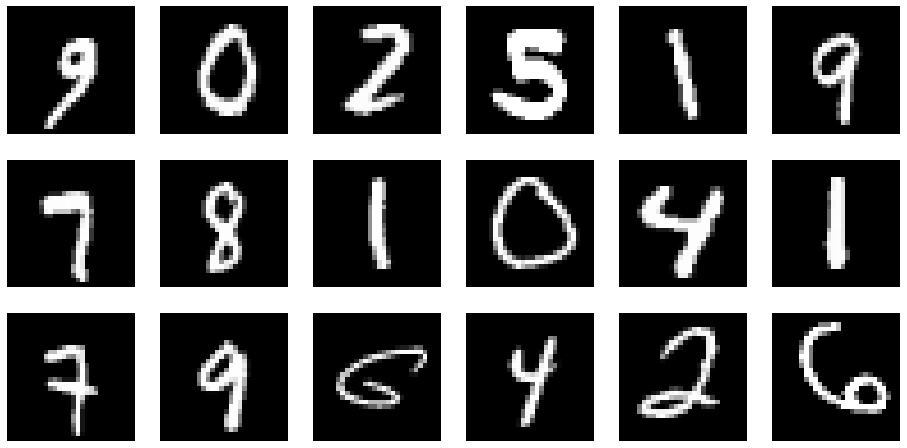

In [15]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_examples[i], cmap="gray")
    plt.axis("off")
plt.show()

In [16]:
def show_dataset_and_predictions(x, y, model):
    plt.figure(figsize=(16, 8))
    for i in range(0, 18):
        plt.subplot(3, 6, i + 1)
        plt.imshow(x[i], cmap="gray")
            
        # Here
        plt.text(0, 2, s=f"y_true={y[i]}",
              bbox=dict(facecolor='blue', alpha=0.9),
              color="white")
        prediction = model(torch.from_numpy(x[i]).view(-1,1,28,28).double()).detach().numpy()
        prediction = np.argmax(prediction)

        color = "green" if prediction == y[i] else "red"
        plt.text(0, 26, s=f"y_pred={prediction}",
              bbox=dict(facecolor=color, alpha=0.9),
              color="white")

        plt.axis("off")
    plt.show()    

<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


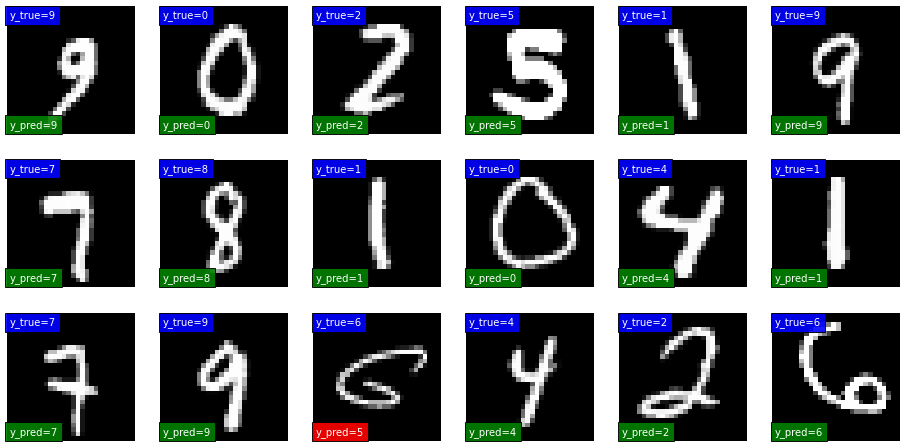

In [17]:
# Check if what you did works
show_dataset_and_predictions(x_examples, y_examples, model)

# An easy adversarial attack

Now we know a bit more how our data looks like, let us dive a bit more into adversarial robustness. First things first, if we want to study the robustness of our model, we need an attack...

## FGSM

FGSM is a widely used attack and still a state-of-the-art one because 1) It is very easy to understand and to implement, 2) It is really quick to run and 3) It works kind of well.

As a reminder, FGSM works as follows:
- It has a parameter "epsilon" which controls the strengh of the attack
- FGSM is going to add epsilon to the input in the same direction of the gradient of the loss function of our model in that input (the idea is that we want to make the loss function higher, so we go in the same direction)

[WHAT YOU HAVE TO DO] Complete the function "fgsm_attack" to implement the attack.

In [18]:
def fgsm_attack(model, x, y, epsilon):
    if type(x) is np.ndarray:
        x = torch.from_numpy(x).view(-1,1,28,28).double()
    else:
        x = x.view(-1,1,28,28).double()
    if isinstance(y, int):
        y = torch.from_numpy(np.array([y]))
    elif type(y) is np.ndarray:
        y = torch.from_numpy(y)
    loss_func = nn.CrossEntropyLoss()
    x.requires_grad = True
            
    y_pred = model(x)
    model.zero_grad()
    loss = loss_func(y_pred, y)
    loss.backward()
    
    x_adv = x + epsilon*x.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    
    return x_adv

<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


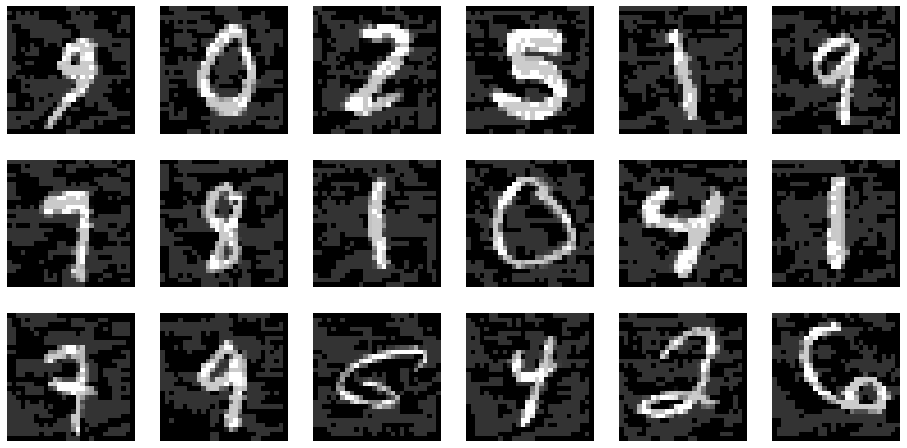

In [19]:
epsilon = 0.2
x_advs = []
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    x_advs.append(fgsm_attack(model, x_examples[i], y_examples[i], epsilon).view(28,28).detach().numpy())
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_advs[i], cmap="gray")
    plt.axis("off")
plt.show()

Now that we have implemented FGSM, let's check is relevance on some examples.

[WHAT YOU NEED TO DO] Run the FGSM on as many examples from x_examples as needed to call the function "show_dataset_and_predictions" so that we have:
- adversarial images displayed (not "clean" ones)
- the true label (of the "clean" image)
- the prediction of the adversarial image

<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


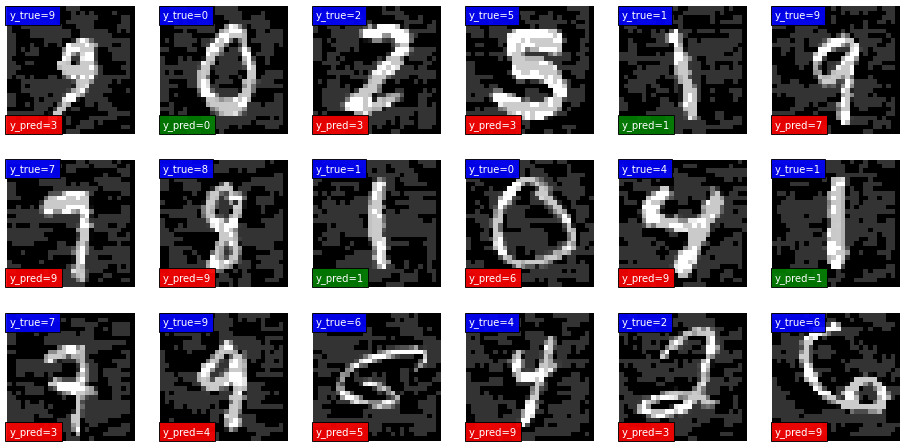

In [21]:
epsilon = 0.2
y_advs = []
x_advs = []
for i in range(0, 18):
    x_adv = fgsm_attack(model, x_examples[i], y_examples[i], epsilon)
    x_advs.append(x_adv.view(28,28).detach().numpy())
    y_pred_adv = model(x_adv)
    y_advs.append(y_pred_adv.argmax(dim=1, keepdim=True))

show_dataset_and_predictions(x_advs, y_examples, model)

Now that we have a better idea of how good FGSM is, it is time to check that on more than a few visual examples. Here, we are going to run FGSM at a larger scale on our test datasets, and measure how accuracy changes with different epsilon paramaters.

[WHAT YOU NEED TO DO] Complete the following function to run FGSM on the complete test dataset and compute its accuracy. Then, plot the accuracy as a function of epsilon (the strengh parameter of the attack).

In [24]:
def run_attack(model, test_loader, epsilon):
    loss_func = nn.CrossEntropyLoss()
    correct = 0
    adv_examples = []

    total_clean_correct = 0
    total_adv_correct = 0
    for x, y in test_loader:
        #x.requires_grad = True
        x = x.double()
        y_pred = model(x)
        y_init_pred = y_pred.argmax(dim=1, keepdim=True)
        
        # How many good predictions model make on the current batch
        #init_correct = sum([1 for i in range(len(y)) if y[i] == y_init_pred[i]])

        x_adv = fgsm_attack(model, x, y, epsilon)
        y_pred_adv = model(x_adv)

        # Check for success
        y_final_pred_adv = y_pred_adv.argmax(dim=1, keepdim=True)
        adv_correct = sum([1 for i in range(len(y)) if (y[i] == y_final_pred_adv[i]) and (y[i] == y_init_pred[i])])
        
        #total_clean_correct += init_correct
        total_adv_correct += adv_correct

    #print(f"Adv correct = {total_adv_correct}")
    return total_adv_correct/float(len(test_loader))

In [23]:
epsilon = 0.2
run_attack(model, test_loader, epsilon)

<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Adv correct = 2166


0.24066666666666667

<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[]

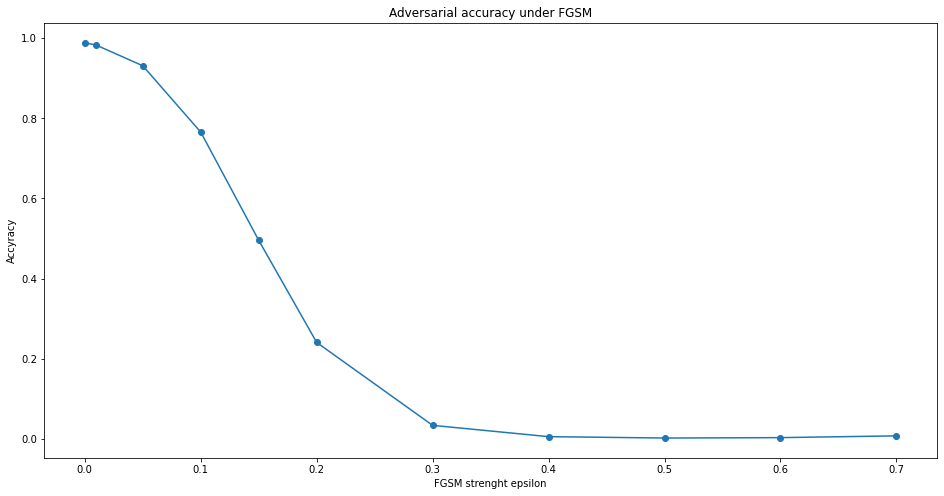

In [25]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
adv_accs = []
for epsilon in epsilons:
    adv_accs.append(run_attack(model, test_loader, epsilon))

plt.figure(figsize=(16, 8))
plt.plot(epsilons, adv_accs, "o-")
plt.xlabel("FGSM strenght epsilon")
plt.ylabel("Accyracy")
plt.title("Adversarial accuracy under FGSM")
plt.plot()

# Visualizing adversarial perturbation

What does the adversarial perturbation look like? Can we see a pattern, can we deduce interesting stuff from there?

To try to answer this questions, we will first zoom on the adversarial perturbation.

[WHAT YOU NEED TO DO] Plot a clean image, its corresponding perturbation and the corresponding adversarial image side by side.

<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Is the attack successful? tensor([[True]])


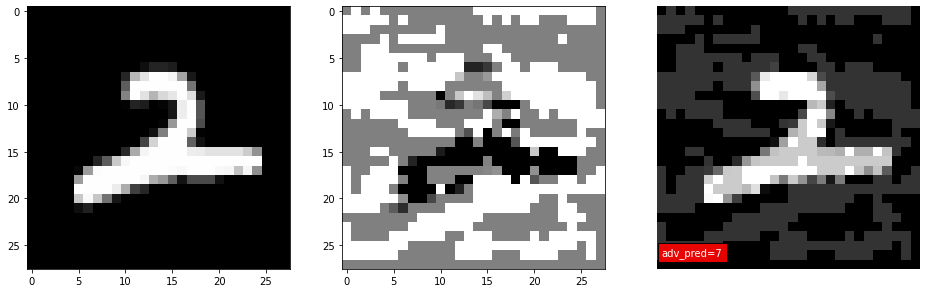

In [26]:
epsilon = 0.2
i = 31

x = x_examples[i]
x_adv = fgsm_attack(model, x, y_examples[i], epsilon)
print(f"Is the attack successful? {(model(x_adv).argmax(dim=1, keepdim=True) != y_examples[i])}")
perturbation = (torch.from_numpy(x) - x_adv).view(28,28).detach().numpy()

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(x, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(-1/epsilon * perturbation, cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(x_adv.view(28,28).detach().numpy(), cmap="gray")
plt.text(0, 26, s=f"adv_pred={int(model(x_adv).argmax(dim=1, keepdim=True))}",
              bbox=dict(facecolor="red", alpha=0.9),
              color="white")
plt.axis("off")
plt.show()

We realize that the attack is quite able to identify the true label, as shown by the black pixels in the perturbation... But it is difficult to see where the adversarial label comes from.

### Saliency map ?

<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


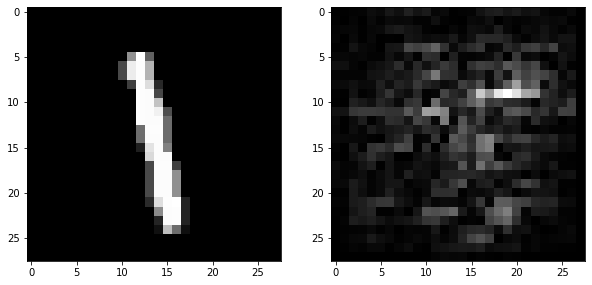

In [37]:
def saliency_map(x,y, model):

    x = torch.from_numpy(x).view(-1,1,28,28).double()
    x.requires_grad = True

    pred = model(x)
    score, ind = torch.max(pred, 1)
    score.backward()
    slc, _ = torch.max(torch.abs(x.grad), dim=0)
    slc = (slc - slc.min())/(slc.max()-slc.min())

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(x.detach().view(28,28).numpy(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(slc.view(28,28).numpy(), cmap="gray")
    plt.show()
    
    return slc

i = 4
slc = saliency_map(x_examples[i],y_examples[i], model)

# Adversarial Training

In [29]:
epochs = 10
model_adv = get_deep_model(epochs, adv=True)

Retraining /Users/m.goibert/Documents/Criteo/TP_adv_Robustness/trained_models/MNIST_LeNet_10_epochs_adv_training.model
Starting epoch 0 (4.291534423828125e-06 secs) and lr = [0.001]


<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Validation loss = 0.3906
Starting epoch 1 (63.14278793334961 secs) and lr = [0.001]
Validation loss = 0.2979
Starting epoch 2 (59.65834403038025 secs) and lr = [0.001]
Validation loss = 0.2522
Starting epoch 3 (58.21780586242676 secs) and lr = [0.001]
Validation loss = 0.2332
Starting epoch 4 (57.016685962677 secs) and lr = [0.001]
Validation loss = 0.2123
Starting epoch 5 (58.36688995361328 secs) and lr = [0.001]
Validation loss = 0.2062
Starting epoch 6 (58.26809477806091 secs) and lr = [0.001]
Validation loss = 0.2001
Starting epoch 7 (64.27405500411987 secs) and lr = [0.001]
Validation loss = 0.1829
Starting epoch 8 (55.548393964767456 secs) and lr = [0.001]
Validation loss = 0.1667
Starting epoch 9 (51.723921060562134 secs) and lr = [0.001]
Validation loss = 0.1718
Validation accuracy = 0.983
Test accuracy = 0.9832222222222222


<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[]

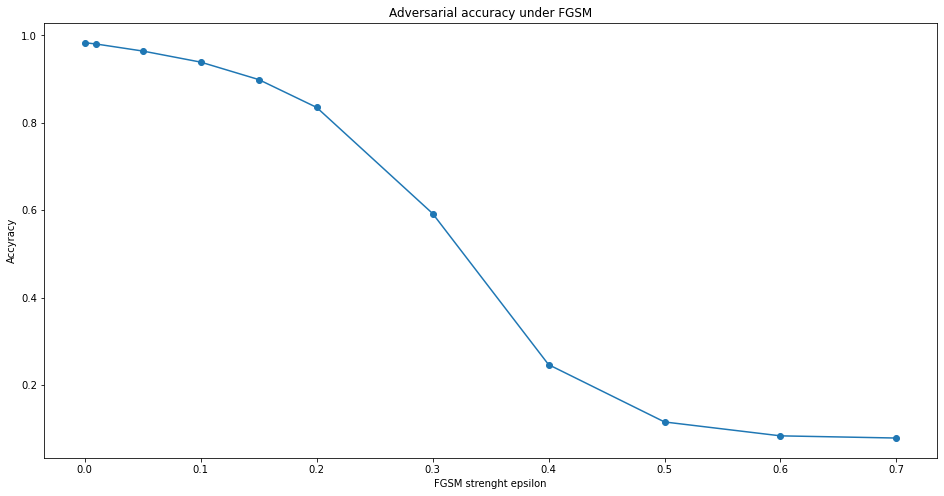

In [30]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
adv_accs = []
for epsilon in epsilons:
    adv_accs.append(run_attack(model_adv, test_loader, epsilon))

plt.figure(figsize=(16, 8))
plt.plot(epsilons, adv_accs, "o-")
plt.xlabel("FGSM strenght epsilon")
plt.ylabel("Accyracy")
plt.title("Adversarial accuracy under FGSM")
plt.plot()

<ipython-input-5-0b41f8b9508c>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


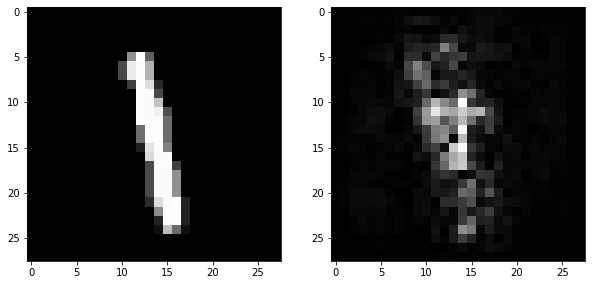

In [36]:
i = 4
slc = saliency_map(x_examples[i],y_examples[i], model_adv)